# <center><font color=|green|>Assignment 3 - Convection of a Scalar</font></center>
# <center><font color=|green|>Problem 2</font></center>
Solve the following problem and explain your results.

Consider the problem of water flowing through a heated square duct (see the figure below).

![Problem1](3-Problem2.png)

The properties of water are $\rho$ = 1000 [kg/m$^3$], $k$ = 0.590 [W/m$\cdot$K], and $c_p$ = 4189 [J/kg$\cdot$K]. The exact solution for this problem is:

$$
    \frac{T_{\infty}-T(x)}{T_{\infty}-T_{in}}= e^{-\frac{h P_o x}{\dot{m} c_p}}
$$

To solve this problem, start with 5 equal-length control volumes, initialize the temperature and velocity fields as $T$ = 0 [$^\circ$C] and $u$ = 1.5 [m/s], and use a time-step size of $10^{10}$ [s].  At the left boundary, set $\alpha_e = 1$ to ensure that the correct value of $T$ gets carried into the domain.  Then, carry out the following:

1. Solve the problem using UDS, CDS and QUICK and plot $T$ for all schemes along with $T_{exact}$ vs. $x$ with $\alpha_e$ = -1.0 at the right boundary.  Discuss the results.
2. Test the effect of $\alpha_e$ at the right boundary.  That is, set $\alpha_e$ = 1.0 at the right boundary, run the cases of (1) again and discuss the differences that occur.  What physical effect does setting $\alpha_e = \pm1.0$ at the right boundary have?  Which is realistic?
3. Reverse the flow direction and the boundary conditions re-run parts (1) and (2).  Show plots of $T$ vs. $x$.  Make sure you use appropriate values for $\alpha_e$ on the boundaries.  Your solutions should be the same as those from parts (1) and (2), except opposite.

Based on your results for this problem, make a general statement about how $\alpha_e$ should be set on the boundaries and why.

-------------------------------------------------------------------------------------------------------------------------------
# <center><font color=|green|>Solution of Problem 2</font></center>
-------------------------------------------------------------------------------------------------------------------------------

In this problem, a heated square duct is taken into consideration through which water is flowing (as shown in Figure above). The properties of water as well as the exact solution of the problem is given. Now, it is required to solve the problem employing three schemes (UDS, CDS and QUICK). In order to do this, the entire domain is divided into 5 equal control volumes and temperature and velocity fields are initialized as per the given values in the question i.e., $T$ = 0 [$^\circ$C] and $u$ = 1.5 [m/s]. The timestep considered is of size $10^{10}$ [s]. With these initial considerations, the problem is solved into three parts as given below.

Here an ouline is given describing the way the solution is obtained for this problem:

- Initially necessary functions are called
- A model corresponding to UDS scheme is presented
- A function is created which employs UDS to solve the problem
- A model corresponding to CDS scheme is presented
- A function is created which employs CDS to solve the problem
- A model corresponding to QUICK scheme is presented
- A function is created which employs QUICK to solve the problem
- A function is created to carry out the analytical solution
- A function is created which combines solution through all the ways described above
- Above fuctionas are created in such a way so that it can take the inputs from all the parts of the problem
- Necessary inputs are taken from the first part of the problem and it solves the problem through all the three schemes along with the analytical solution accordingly
- Discussion is presented based on the results obtained from first part of the problem
- In this part the value of $\alpha_e$ at the right boundary is set to 1 to test the effect this change in $\alpha_e$ at the right boundary   
- Discussion is presented based on the results obtained from second part of the problem describing the physical effects of setting $\alpha_e = \pm1.0$ at the right boundary and which one is more realistic
- Then, the first part of the problem is solved by reversing the flow direction and boudary conditions as well by taking appropriate values of $\alpha_e $ at the right boundary
- The results obtained through above step are discussed
- Next, the second part of the problem is solved by reversing the flow direction as well the boudary conditions 
- A discussion is presented describing the results obtained through above step
- Based on the results achieved through above steps, a general comment is presented on how $\alpha_e$ should be set on the boundaries along with appropriate reasoning.
- Finally a comment is made on the number of iterations taken by different schemes (UDS, CDS and QUICK)



In [1]:
from Lesson4.Grid import Grid
from Lesson4.ScalarCoeffs import ScalarCoeffs
from Lesson4.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson4.Models import DiffusionModel, SurfaceConvectionModel, FirstOrderTransientModel
from Lesson4.LinearSolver import solve

In the all of the following cells of code the segment which is modified are put within the dashed lines and appropriate comments are added.

# <center><font color=|blue|>UDS Scheme </font></center>

In [2]:
import numpy as np

class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc, alphaeatLB, alphaeatRB):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        
        self._alphaeatLB = alphaeatLB # This is newly added to specify the value of alphae at the left boundary
        self._alphaeatRB = alphaeatRB # This is newly added to specify the value of alphae at the right boundary

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
#---------------------------------------------------------------------------------------------------------------------------- 
        # Calculate the weighting factors
        self._alphae[0]= self._alphaeatLB # This is newly added to specify the value of alphae at the left boundary
        for i in range(1,self._grid.ncv):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[self._grid.ncv] = self._alphaeatRB # This is newly added to specify the value of alphae at the right boundary
#---------------------------------------------------------------------------------------------------------------------------- 
        # Calculate the east integration point values (including both boundaries)

        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
               
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In the follwing segment of code, various values of different parameter are changed according to the values specified in the question

In [3]:
def solbyUDS(U0, alphaeatLB, alphaeatRB):    
    import numpy as np
    from numpy.linalg import norm


    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp  = 4189
    k   = 0.590

    # Define the surface convection parameters
    ho = 10000 
    To = 100 

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    if U0 > 0:
        west_bc = DirichletBc(T, grid, 0, BoundaryLocation.WEST)
        east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)
    else :
        west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
        east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc, alphaeatLB, alphaeatRB)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
    return T 

# <center><font color=|blue|>CDS Scheme </font></center>

In [4]:
import numpy as np

class CentralAdvectionModel:
    """Class defining an Central advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc,alphaeatLB,alphaeatRB):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
#----------------------------------------------------------------------------------------------------------------------------
        self._alphaeatLB = alphaeatLB # This is newly added to specify the value of alphae at the left boundary
        self._alphaeatRB = alphaeatRB # This is newly added to specify the value of alphae at the right boundary
#----------------------------------------------------------------------------------------------------------------------------

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
#---------------------------------------------------------------------------------------------------------------------------- 
        # Calculate the weighting factors
        self._alphae[0] = self._alphaeatLB # This is newly added to specify the value of alphae at the left boundary
        for i in range(1,self._grid.ncv):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[self._grid.ncv] = self._alphaeatRB # This is newly added to specify the value of alphae at the right boundary
#----------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------- 
# The following segment is coded to calculate the east integration point values and values at boundaries according to the 
# background theory of CDS scheme

        # Calculate the east integration point values and values at boundaries      
        # For cells
        for i in range(1,self._grid.ncv):
            self._phie[i] = (1/2)*self._phi[i] + (1/2)*self._phi[i+1]
            
        # For boundaries
        # At the left boundary 
        self._phie[0] = ((1 + self._alphae[0])/2)*self._phi[0] + ((1 - self._alphae[0])/2)*self._phi[1]
        # At the right boundary
        self._phie[-1] = ((1 + self._alphae[self._grid.ncv])/2)*self._phi[-2] + ((1 - self._alphae[self._grid.ncv])/2)*self._phi[-1]

#---------------------------------------------------------------------------------------------------------------------------- 

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In the follwing segment of code, various values of different parameter are changed according to the values specified in the question

In [5]:
def solbyCDS(U0, alphaeatLB, alphaeatRB):      
    import numpy as np
    from numpy.linalg import norm


    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp  = 4189
    k   = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 100 

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0  

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    if U0 > 0:
        west_bc = DirichletBc(T, grid, 0, BoundaryLocation.WEST)
        east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)
    else :
        west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
        east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = CentralAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc, alphaeatLB, alphaeatRB)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
    return T 

# <center><font color=|blue|>QUICK Scheme </font></center>

In [6]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining an Central advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc,alphaeatLB, alphaeatRB):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
#----------------------------------------------------------------------------------------------------------------------------
        self._alphaeatLB=alphaeatLB # This is newly added to specify the value of alphae at the left boundary
        self._alphaeatRB=alphaeatRB # This is newly added to specify the value of alphae at the right boundary
#----------------------------------------------------------------------------------------------------------------------------

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
#---------------------------------------------------------------------------------------------------------------------------- 
        # Calculate the weighting factors
        self._alphae[0] = self._alphaeatLB # This is newly added to specify the value of alphae at the left boundary
        for i in range(1,self._grid.ncv):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[self._grid.ncv]=self._alphaeatRB # This is newly added to specify the value of alphae at the right boundary
#---------------------------------------------------------------------------------------------------------------------------- 
        
#---------------------------------------------------------------------------------------------------------------------------- 
# The following segment is coded to calculate the east integration point values and values at boundaries according to the 
# background theory of QUICK scheme


        # Calculate the east integration point values and values at boundaries
        # For cells
        for i in range (1,self._grid.ncv): 
            if self._Uhe[i] < 0:
            # for flow in negative direction
                s = ((grid.xf[i] - grid.xP[i+1])*(grid.xf[i] - grid.xP[i]))/((grid.xP[i+2] - grid.xP[i+1])*(grid.xP[i+2] - grid.xP[i]))
                t = ((grid.xf[i] - grid.xP[i+2])*(grid.xf[i] - grid.xP[i]))/((grid.xP[i+1] - grid.xP[i+2])*(grid.xP[i+1] - grid.xP[i]))
                u = ((grid.xf[i] - grid.xP[i+1])*(grid.xf[i] - grid.xP[i+2]))/((grid.xP[i] - grid.xP[i+1])*(grid.xP[i] - grid.xP[i+2]))
                self._phie[i] = s*self._phi[i+2] + t*self._phi[i+1] + u*self._phi[i]
             
            else:
                # for flow in positive direction
                p = ((grid.xf[i] - grid.xP[i])*(grid.xf[i] - grid.xP[i+1]))/((grid.xP[i-1] - grid.xP[i])*(grid.xP[i-1] - grid.xP[i+1]))
                q = ((grid.xf[i] - grid.xP[i-1])*(grid.xf[i] - grid.xP[i+1]))/((grid.xP[i] - grid.xP[i-1])*(grid.xP[i] - grid.xP[i+1]))
                r = ((grid.xf[i] - grid.xP[i-1])*(grid.xf[i] - grid.xP[i]))/((grid.xP[i+1] - grid.xP[i-1])*(grid.xP[i+1] - grid.xP[i]))
                self._phie[i] = p*self._phi[i-1] + q*self._phi[i] + r*self._phi[i+1]
                    
        
        # For boundaries
        # At the left boundary 
        self._phie[0] = ((1 + self._alphae[0])/2)*self._phi[0] + ((1 - self._alphae[0])/2)*self._phi[1]
        # At the right boundary
        self._phie[-1] = ((1 + self._alphae[self._grid.ncv])/2)*self._phi[-2] + ((1 - self._alphae[self._grid.ncv])/2)*self._phi[-1]
#---------------------------------------------------------------------------------------------------------------------------- 
      
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In the follwing segment of code, various values of different parameter are changed according to the values specified in the question

In [7]:
def solbyQUICK(U0, alphaeatLB, alphaeatRB):    
    import numpy as np
    from numpy.linalg import norm


    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp  = 4189
    k   = 0.590

    # Define the surface convection parameters
    ho = 10000 
    To = 100 

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    if U0 > 0:
        west_bc = DirichletBc(T, grid, 0, BoundaryLocation.WEST)
        east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)
    else :
        west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
        east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc, alphaeatLB, alphaeatRB)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
    return T 

# <center><font color=|blue|>Analytical Solution</font></center>

The properties of water are $\rho$ = 1000 [kg/m$^3$], $k$ = 0.590 [W/m$\cdot$K], and $c_p$ = 4189 [J/kg$\cdot$K]. The exact solution for this problem is:

$$
    \frac{T_{\infty}-T(x)}{T_{\infty}-T_{in}}= e^{-\frac{h P_o x}{\dot{m} c_p}}
$$

To solve this problem, start with 5 equal-length control volumes, initialize the temperature and velocity fields as $T$ = 0 [$^\circ$C]and $u$ = 1.5 [m/s], and use a time-step size of $10^{10}$ [s]. 

In [8]:
def analyticalsol(U0):     
    %matplotlib inline
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    x = np.linspace(0,5,7)
    rho = 1000
    Po = 4*.01
    Tinf = 100
    Tin = 0
    ho = 10000
    cp  = 4189
    ly = 0.01
    lz = 0.01
    mdot = np.abs(rho*ly*lz* U0)

    if U0 > 0:
        Texact = Tinf-((Tinf-Tin)*np.exp((-ho*Po*x)/(mdot*cp)))
    else:
        Texact = np.flip(Tinf-((Tinf-Tin)*np.exp((-ho*Po*x)/(mdot*cp))),0)
    return Texact

In [9]:
def combinedsoln(U0, alphaeatLB, alphaeatRB):
    %matplotlib inline
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    
    TEXACT = analyticalsol(U0)
    x = np.linspace(0,5,7)
    plt.plot(x, TEXACT)
    plt.title('Variation of TEXACT with respect to position(x)')
    plt.xlabel("x")
    plt.ylabel("T")
    plt.show()
    
    TUDS = solbyUDS(U0, alphaeatLB, alphaeatRB)
    plt.plot(grid.xP, TUDS)
    plt.title('Variation of TUDS with respect to position(x)')
    plt.xlabel("x")
    plt.ylabel("T")
    plt.show()

    TCDS = solbyCDS(U0, alphaeatLB, alphaeatRB)
    plt.plot(grid.xP, TCDS)
    plt.title('Variation of TCDS with respect to position(x)')
    plt.xlabel("x")
    plt.ylabel("T")
    plt.show()

    TQUICK = solbyQUICK(U0, alphaeatLB, alphaeatRB)
    plt.plot(grid.xP, TQUICK)
    plt.title('Variation of TQUICK with respect to position(x)')
    plt.xlabel("x")
    plt.ylabel("T")
    plt.show()

    plt.plot(x, TEXACT , '-', label='TEXACT')
    plt.plot(grid.xP, TUDS , '-', label='TUDS')
    plt.plot(grid.xP, TCDS , '-', label='TCDS')
    plt.plot(grid.xP, TQUICK , '-', label='TQUICK')
    plt.legend()
    plt.title('Comparative Variation of temperature with respect to position(x)')
    plt.xlabel("x")
    plt.ylabel("T")
    plt.show()

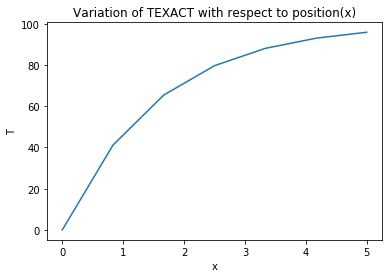

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 1.0982930767474634e-11; Avg. Resid. = 4.9671319592599885e-12


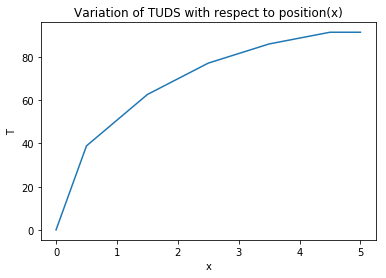

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7467.089245844104; Avg. Resid. = 2986.835698337645
Iteration = 2; Max. Resid. = 1774.7247010436342; Avg. Resid. = 748.0769462738367
Iteration = 3; Max. Resid. = 527.2549491781442; Avg. Resid. = 276.86347268320395
Iteration = 4; Max. Resid. = 175.43990304167752; Avg. Resid. = 112.97284618841806
Iteration = 5; Max. Resid. = 96.91092775632511; Avg. Resid. = 45.318183232160074
Iteration = 6; Max. Resid. = 60.57660800011754; Avg. Resid. = 25.832994433109455
Iteration = 7; Max. Resid. = 36.8209038185603; Avg. Resid. = 18.03290727423807
Iteration = 8; Max. Resid. = 23.563683594842907; Avg. Resid. = 12.908598540918167
Iteration = 9; Max. Resid. = 17.116872367966096; Avg. Resid. = 8.64890903595936


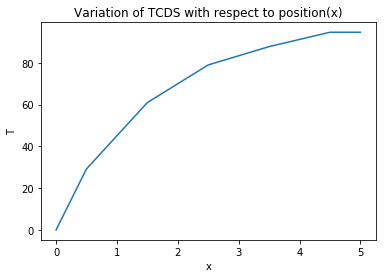

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.090500306731; Avg. Resid. = 5250.036200122696
Iteration = 2; Max. Resid. = 1513.539118728763; Avg. Resid. = 605.4156474915045
Iteration = 3; Max. Resid. = 594.495479182198; Avg. Resid. = 237.7981916728798
Iteration = 4; Max. Resid. = 106.48614838810884; Avg. Resid. = 52.86685140503463
Iteration = 5; Max. Resid. = 24.595793477302514; Avg. Resid. = 9.838317390921416
Iteration = 6; Max. Resid. = 8.04448167812734; Avg. Resid. = 4.579300213381011
Iteration = 7; Max. Resid. = 3.162845284060915; Avg. Resid. = 1.695914857836486
Iteration = 8; Max. Resid. = 0.8861230450981812; Avg. Resid. = 0.5395651734445825
Iteration = 9; Max. Resid. = 0.40393433827429054; Avg. Resid. = 0.16157373530944408


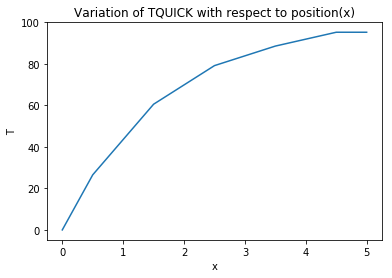

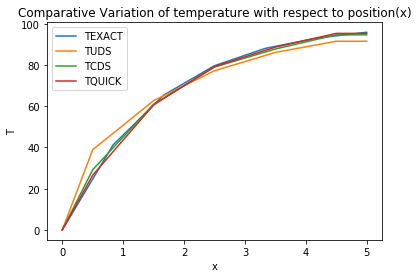

In [10]:
# 2.1
# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)
U0 = 1.5
alphaeatLB = 1
alphaeatRB = -1
combinedsoln(U0, alphaeatLB, alphaeatRB)


## <center><font color=|blue|>2.1 (i.e., part 1 of Problem 2)</font></center>


In the first part of this problem, different convection schemes UDS (Upwind Difference Scheme), CDS (Central Difference Scheme), QUICK (Quadratic Upwind Interpolation for Convective Kinematics) are used to solve the problem considering the timestep size as $10^{10}$ [s].The total number of control volumes is 5. The temperature and velocity fields are initialized as $T$ = 0 [$^\circ$C] and $u$ = 1.5 [m/s]

For doing this, an individual model is programmed for each scheme and then the problem is solved through applying those schemes.

Along with the results obtained from the three schemes, analytical results (named as Texact) are calculated as well. Results of analytical solution for T along with the results for T obtained through applying the three schemes (UDS, CDS, QUICK) are plotted in a comparative graph.


- Discussion of the results:
  
The comparative graph represents the results of three schemes along with the analytical solution. It clearly shows that the results obtained through higer order sceme i.e., CDS and QUICK are much closer to the analytical result compared to UDS. In other way UDS gives the most deviated result from the analytical solution. The reason for such results produced by UDS are it's first order accuracy and false diffusion. The explanation of these two factors were presented in the solution of part 3 of Problem 1. The same explanation is applicable in this case as well. 
  
Explanation of False Diffusion:
  
It is known that the ratio of false diffusion to real diffusion is given by:

$$ \frac{\Gamma^{false}}{\Gamma^{real}} = \frac{1}{2}\text{Re}_\Delta \text{Pr} = \frac{1}{2}\text{Pe}_\Delta $$

So, this false diffusion is proportional to Peclet number. The Peclet number is given by

$$ \text{Pe}_\Delta = \frac{u\Delta x}{\alpha}$$

This equation shows that, Peclet number is proportional to grid size. 

Combining the above two equations give

$$ \frac{\Gamma^{false}}{\Gamma^{real}} = \frac{1}{2}\text{Re}_\Delta \text{Pr} = \frac{1}{2}\text{Pe}_\Delta =\frac{1}{2}\frac{u\Delta x}{\alpha} $$ 

Mathematically, 

For 5 control volumes:

$\alpha$ = 0.0000001408 [m^2/s] [Calculated from k, $\rho$, $c_p $]

$$ \frac{\Gamma^{false}}{\Gamma^{real}} =\frac{1}{2}\frac{1.5 X 1}{0.0000001408} = 5.32 X 10^{6} $$

Due to the presence of this false diffusion, UDS shows maximum deviation from the analytical solution, compared to CDS and QUICK.


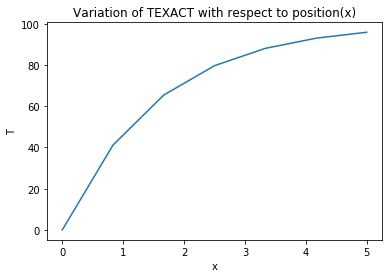

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 1.0982930767474634e-11; Avg. Resid. = 4.9671319592599885e-12


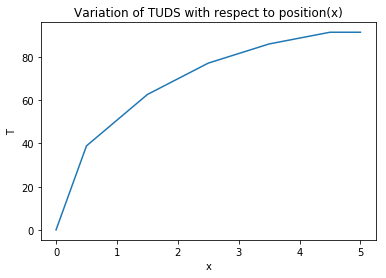

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7467.089245844104; Avg. Resid. = 2986.835698337645
Iteration = 2; Max. Resid. = 1774.7247010436342; Avg. Resid. = 748.0769462738367
Iteration = 3; Max. Resid. = 527.2549491781442; Avg. Resid. = 276.86347268320395
Iteration = 4; Max. Resid. = 175.43990304167752; Avg. Resid. = 112.97284618841806
Iteration = 5; Max. Resid. = 96.91092775632511; Avg. Resid. = 45.318183232160074
Iteration = 6; Max. Resid. = 60.57660800011754; Avg. Resid. = 25.832994433109455
Iteration = 7; Max. Resid. = 36.8209038185603; Avg. Resid. = 18.03290727423807
Iteration = 8; Max. Resid. = 23.563683594842907; Avg. Resid. = 12.908598540918167
Iteration = 9; Max. Resid. = 17.116872367966096; Avg. Resid. = 8.64890903595936


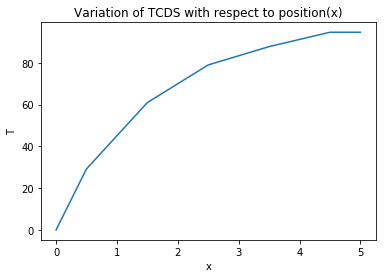

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.090500306731; Avg. Resid. = 5250.036200122696
Iteration = 2; Max. Resid. = 1513.539118728763; Avg. Resid. = 605.4156474915045
Iteration = 3; Max. Resid. = 594.495479182198; Avg. Resid. = 237.7981916728798
Iteration = 4; Max. Resid. = 106.48614838810884; Avg. Resid. = 52.86685140503463
Iteration = 5; Max. Resid. = 24.595793477302514; Avg. Resid. = 9.838317390921416
Iteration = 6; Max. Resid. = 8.04448167812734; Avg. Resid. = 4.579300213381011
Iteration = 7; Max. Resid. = 3.162845284060915; Avg. Resid. = 1.695914857836486
Iteration = 8; Max. Resid. = 0.8861230450981812; Avg. Resid. = 0.5395651734445825
Iteration = 9; Max. Resid. = 0.40393433827429054; Avg. Resid. = 0.16157373530944408


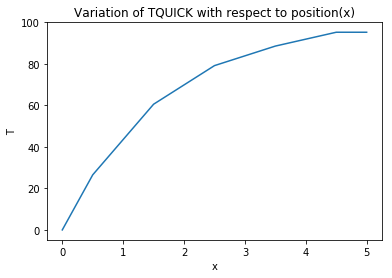

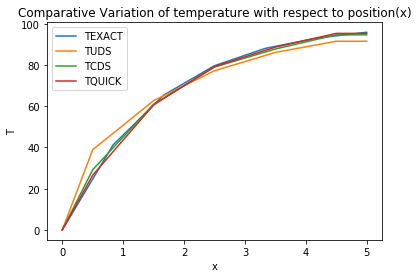

In [11]:
# 2.2
U0 = 1.5
alphaeatLB = 1
alphaeatRB = 1
combinedsoln(U0, alphaeatLB, alphaeatRB)

## <center><font color=|blue|>2.2 (i.e., part 2 of Problem 2)</font></center>

 In this part of problem, $\alpha_e$ at the right boundary is set to be 1 to test the effect of this change and the cases of part 1 of Problem 2 are re-run. Individual graph has been plotted for each of the schemes and a comparative graph is drawn as well to compare the results of three schemes with analytical result. As the aim of this part of the problem is to test the effect of $\alpha_e$ at the right boundary so it is discussed below:


- Effect of $\alpha_e$ at the right boundary:

By setting $\alpha_e$ = -1.0 at the right boundary the set of graphs which was obtained in the previous part of the problem, after setting $\alpha_e$ = 1.0 at the right boundary, running the cases reproduces the same set of graphs and no difference was noticed. 

- Physical effect of setting $\alpha_e = \pm1.0$ at the right boundary

  Physical effect of setting $\alpha_e$ = 1.0 at the right boundary:
  
  For $\alpha_e = 1$; $ T_e = T_P $ that is the value of temperature at the boundary is taken from the cell adjacent to the boundary.

  Physical effect of setting $\alpha_e$ = 1.0 at the right boundary:
  
  For $\alpha_e = -1$; $ T_e = T_E $ that is the value of temperature at the right boundary is equal to the temperature of the virtual control volume at the right boundary.
  
  Again, at the right boundary Neumann Boundary condition is applied which means the temperature of the cell adjacent to the right boundary ($ T_P $) is equal to the temperature of the virtual control volume at the right boundary ($ T_E $). i.e.,
  $ T_P $ = $ T_E $

  If effects of setting $\alpha_e = \pm1.0$ are combined then it also gives the same i.e., 
 $ T_e = T_P  = T_E $
 
  That is why, for this problem setting $\alpha_e = \pm1.0$ does not have any effect.
  
  However, if the Neumann boundary condition would not be applied at the right boundary, then setting $\alpha_e = \pm1.0$ at the right boundary would have significant effect on the results obtained.
  

- Out of $\alpha_e = \pm1.0$ which is more realistic?
    
    This can be discussed from two perspective:
    From mathematical point of view as well as from physical point of view

    From mathematical point of view:

    The list of values of different parameter is given by:

Parameters          | Valiue                     | Remarks
:----------:        | :------------------------: |:------------------------:
L                   | 5 [m]                      |Given
k                   | 0.59 [W/m$\cdot$K]         |Given
$\rho$              | 1000 [kg/m^3]              |Given
$c_p $              | 4189 [J/kgK]               |Given
$T $                | 100 [$^\circ$C]            |Given
$T_in $             | 0 [$^\circ$C]              |Given
$u$                 | 1.5[m/s]                   |Given 
$\alpha$            | 0.0000001408 [m^2/s]       |Calculated from k, $\rho$, $c_p $ 

For number of control volume = 5

$$\Delta x = \frac{total length of the domain}{ number of control volume} = \frac{5}{ 5}=  1 $$

$$\Delta x_\text{at boundary} = \Delta x / 2 = 0.5$$

$$\text{Pe}_\Delta=\frac{u\Delta x_\text{at boundary}}{\alpha} = \frac{ 1.5 X 0.5}{0.0000001408} = 5.326 X 10^6$$

$$A_e = ( 0.01  X  0.01 ) = 0.0001 $$

$$D_e=\frac{k A_e}{\Delta x_\text{at boundary}} = \frac{0.59  X 0.0001 }{0.5} = 1.18 X 10^{-4}  $$^

$$\dot{m}_e = \rho u A_e = 1000 X 1.5 X 0.0001 = 0.15 $$  

$$ a_E = - D_e + \frac{1}{2}c_p\dot{m}_e\left(1 - \alpha_e \right) $$

For CDS, UDS and QUICK:

considering $\alpha_e$ = 1 at the right boundary gives:

$$ a_E = - 1.18 X 10^-4 + \frac{1}{2} 4189 X 0.15 X \left(1 - 1 \right) = - 1.18 X 10^{-4} + 0 = (-)ve$$  

considering $\alpha_e$ = -1 at the right boundary gives:

$$ a_E = - 1.18 X 10^-4 + \frac{1}{2} 4189 X 0.15 X \left(1 + 1 \right) = - 1.18 X 10^{-4} + 628.35 = 628.349 = (+)ve$$

Here, Peclet number is much gretaer than 1. 
This indicates that the problem is convection dominated.Because it is known that
based on the magnitude of $\text{Pe}_\Delta$ different flow regimes can be identified:

- $\text{Pe}_\Delta \approx 0$: diffusion dominated
- $|\text{Pe}_\Delta| \approx 1$: convection and diffusion
- $|\text{Pe}_\Delta| \gg 1$: convection dominated

So for this problem "Rule 2" can be invoked. 
After invoking "Rule 2" it is observed that as consideration of $\alpha_e$ = -1 at the right boundary gives positive $a_E$ which clearly violates "Rule 2" whereas consideration of $\alpha_e$ = 1 at the right boundary gives negative $a_E$ which does not  violate "Rule 2". So, from mathematical point of view $\alpha_e$ should be set as 1 at the right boundary.


As a quick recall Rule 2 is given here:

**Rule 2: Positive $a_P$ coefficient and negative $a_{nb}$ coefficients** In situations involving convection and diffusion, it is reasonable to assume that an increase in $\phi$ and one control volume should lead to an increase in $\phi$ at neighbouring control volumes, where all other conditions are the unchanged. This requires that $a_P$ has opposite sign from each of its $a_{nb}$ coefficients, such that $\delta\phi_P$ and $\delta\phi_{nb}$ have the same sign, where $r_P$ is assumed to be unchanged. Note that this rule is modified from that of Patankar, since we have kept all $nb$ coefficients on the same side of the equation as the $a_P$ coefficient. This is more natural in the context of the formulation given here, where the algebraic equations are formulated in terms of solution corrections rather than the solution values themselves. Although these approaches are closely related, there are some advantages to the correction-based approach (e.g. and initial guess of $\Delta \phi = 0$ can always be made since this is correct at convergece).

[Reference: Taken from the class lecture of Professor DeGroot]


From physical point of view:

when $\alpha_e$ = 1.0 at the right boundary it means $ T_e = T_P $ i.e., the content of the adjacent call to the boundary is     contained to the boundary which makes sense from physical point of view.

So, $\alpha_e$ should be set as 1 at the right boundary.

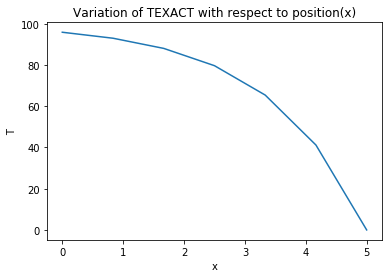

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 1.0982930767474634e-11; Avg. Resid. = 4.759368863371718e-12


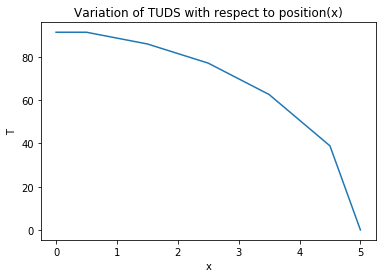

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7467.089245844104; Avg. Resid. = 2986.835698337646
Iteration = 2; Max. Resid. = 1774.7247010436342; Avg. Resid. = 748.0769462738366
Iteration = 3; Max. Resid. = 527.2549491781442; Avg. Resid. = 276.86347268320395
Iteration = 4; Max. Resid. = 175.43990304167752; Avg. Resid. = 112.97284618841806
Iteration = 5; Max. Resid. = 96.91092775632511; Avg. Resid. = 45.318183232160074
Iteration = 6; Max. Resid. = 60.57660800011754; Avg. Resid. = 25.832994433109455
Iteration = 7; Max. Resid. = 36.8209038185603; Avg. Resid. = 18.03290727423807
Iteration = 8; Max. Resid. = 23.563683594842907; Avg. Resid. = 12.908598540918167
Iteration = 9; Max. Resid. = 17.116872367966096; Avg. Resid. = 8.64890903595936


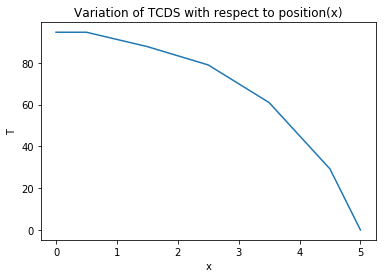

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.090500306731; Avg. Resid. = 5250.036200122697
Iteration = 2; Max. Resid. = 1513.539118728763; Avg. Resid. = 605.4156474915055
Iteration = 3; Max. Resid. = 594.495479182198; Avg. Resid. = 237.79819167287982
Iteration = 4; Max. Resid. = 106.48614838810884; Avg. Resid. = 52.866851405034616
Iteration = 5; Max. Resid. = 24.595793477302514; Avg. Resid. = 9.838317390921416
Iteration = 6; Max. Resid. = 8.04448167812734; Avg. Resid. = 4.579300213381011
Iteration = 7; Max. Resid. = 3.162845284060915; Avg. Resid. = 1.695914857836486
Iteration = 8; Max. Resid. = 0.8861230450981812; Avg. Resid. = 0.5395651734445825
Iteration = 9; Max. Resid. = 0.40393433827429054; Avg. Resid. = 0.1615737353094441


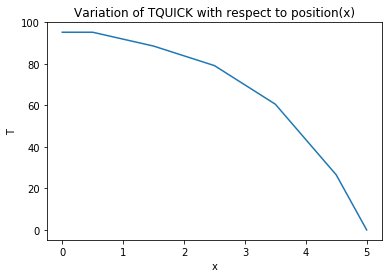

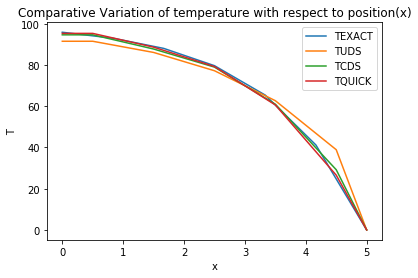

In [12]:
# 2.3 part 1
U0 = -1.5
alphaeatLB = 1
alphaeatRB = -1
combinedsoln(U0, alphaeatLB, alphaeatRB)

For this part of the problem the flow direction as well as the boundary conditions are reversed. Appropriate values for $\alpha_e$ on the boundaries were used. Then, part 1 of the problem is run and $T$ vs. $x$ is plotted. This plot is exactly the same as it was achieved for part 1 of the problem except opposite. 

Individual plots for the results obtained by UDS, CDS and QUICK as well as the analytical method have been presented. Finally they are drawn in a comparative graph in order to show the comparison. It is observed that among the three schemes, UDS gives the worst result. This is due to the first order accuracy of this method as well as the false diffusion introduced by this method. These two reasons are explained already in the earlier part of the problem.



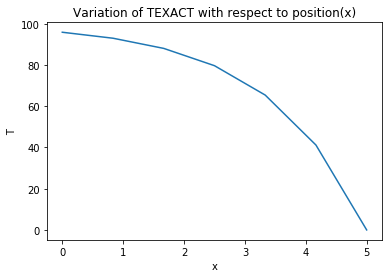

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 1.0982930767474634e-11; Avg. Resid. = 4.759368863371718e-12


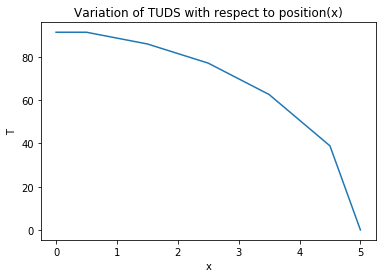

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 7467.089245844104; Avg. Resid. = 2986.835698337646
Iteration = 2; Max. Resid. = 1774.7247010436342; Avg. Resid. = 748.0769462738366
Iteration = 3; Max. Resid. = 527.2549491781442; Avg. Resid. = 276.86347268320395
Iteration = 4; Max. Resid. = 175.43990304167752; Avg. Resid. = 112.97284618841806
Iteration = 5; Max. Resid. = 96.91092775632511; Avg. Resid. = 45.318183232160074
Iteration = 6; Max. Resid. = 60.57660800011754; Avg. Resid. = 25.832994433109455
Iteration = 7; Max. Resid. = 36.8209038185603; Avg. Resid. = 18.03290727423807
Iteration = 8; Max. Resid. = 23.563683594842907; Avg. Resid. = 12.908598540918167
Iteration = 9; Max. Resid. = 17.116872367966096; Avg. Resid. = 8.64890903595936


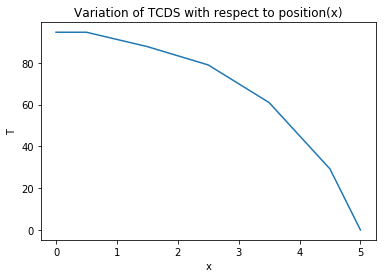

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.090500306731; Avg. Resid. = 5250.036200122697
Iteration = 2; Max. Resid. = 1513.539118728763; Avg. Resid. = 605.4156474915055
Iteration = 3; Max. Resid. = 594.495479182198; Avg. Resid. = 237.79819167287982
Iteration = 4; Max. Resid. = 106.48614838810884; Avg. Resid. = 52.866851405034616
Iteration = 5; Max. Resid. = 24.595793477302514; Avg. Resid. = 9.838317390921416
Iteration = 6; Max. Resid. = 8.04448167812734; Avg. Resid. = 4.579300213381011
Iteration = 7; Max. Resid. = 3.162845284060915; Avg. Resid. = 1.695914857836486
Iteration = 8; Max. Resid. = 0.8861230450981812; Avg. Resid. = 0.5395651734445825
Iteration = 9; Max. Resid. = 0.40393433827429054; Avg. Resid. = 0.1615737353094441


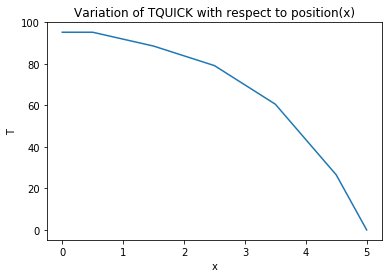

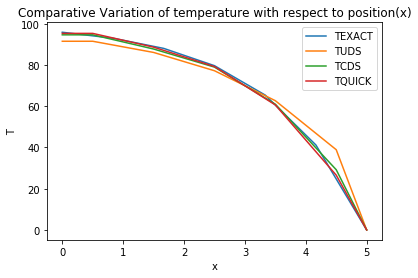

In [13]:
# 2.3 part 2
U0 = -1.5
alphaeatLB = -1
alphaeatRB = -1
combinedsoln(U0, alphaeatLB, alphaeatRB)

The same is done for this part of the problem as the previous part except that now it is done for part 2 of problem 2. Individual results from the three schemes (UDS, CDS & QUICK)as well as the analytical results have been plotted. Then a comparative graph is presented in order to show the comparison of the results obtained from the three schemes with the analytical solution. It shows that UDS gives the worst result among the three schemes (UDS, CDS and QUICK). The reasons are already discussed in the earlier parts of this problem.

- General statement on $\alpha_e$

  This discussion can be divided into two sections: $\alpha_e$ at right boundary and $\alpha_e$ at left boundary.
  

- $\alpha_e$ at right boundary:

    In the second part of this problem it was discussed that how $\alpha_e$ should remain same at the right boundary and why. And it was discussed both from the mathematical and physical point of view. So, that discussion remain valid as a general satement as well i.e., $\alpha_e$ should be set as 1 at the right boundary.
    

- $\alpha_e$ at left boundary:

     From mathematical pont of view: Following the same way as it was shown for the right boundary, it can be shown that setting $\alpha_e = 1 $ results in negative $a_E$ which is inline with Rule 2. So, from this perspective $\alpha_e$ should be set as 1 at the left boundary.
     
     From physical pont of view: Left boundary is the inlet and from physical ponit of view it is expected that, as mass flow is conserved, so the mass enters through the boundary should be carried through the cells which is assured when $\alpha_e$ = 1.0 at the left boundary which means $ T_e = T_P $. So, from physical point of view $\alpha_e$ should be set as 1 at the left boundary. 




- Comment on the number of iteration:

It is observed that in case of UDS, it takes only 1 iteration whereas for higher order schemes i.e., CDS and QUICK it takes more iterations to converge.The reason is explained at the end of problem 1 and it applies here as well.